In [0]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD
from tensorflow.data import Dataset

In [0]:
# Loads CIFAR10 dataset
# 'features' values will have images, 'labels' will have the names represented by the corresponding 'feature' image
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# Function to plot charts showing 'Model Accuracy vs Epoch' and 'Model Loss vs Epoch'
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to calculate the Test Accuracy on test dataset
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Why Float32?
# Using a 32 bit precision is a common approach in neural network training.
# Reason behind is that to make sure that the dataset fits easily in RAM.

# Why dividing by 255?
# 255 is the max pixel value in an image. Dividing all pixel values by 255 ensures that the input features are scaled between 0.0 and 1.0
# Reason behind to scale between 0.0 and 1.0 is to make sure default learning rate works well.

# train_features = train_features.astype('float32')/255
# test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = utils.to_categorical(train_labels, num_classes)
test_labels = utils.to_categorical(test_labels, num_classes)

In [0]:
BATCH_SIZE = 128 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 5e-4 #@param ["0.000125", "0.00025", "0.0005", "5e-4"] {type:"raw"}
LEARNING_RATE = 0.4 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 100 #@param {type:"slider", min:0, max:100, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [0]:
train_mean = np.asarray((0.4914, 0.4822, 0.4465))
train_std = np.asarray((0.2023, 0.1994, 0.2010))

In [0]:
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# Padding and Cropping
train_features = normalize(pad4(train_features))
print(train_features.shape)
test_features = normalize(test_features)


(50000, 40, 40, 3)


In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


## LR Finder

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
#         best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        print(derivatives[n_skip_beginning:-n_skip_end])
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

## Model

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Concatenate, GlobalMaxPool2D, Dense, Flatten, Activation

class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = BatchNormalization(momentum=MOMENTUM, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))


In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res1 = ConvBN(c_out)
    self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    res_layer = self.res2(self.res1(h))
    return Concatenate(axis=1)([h, res_layer])


In [0]:
def DavidNet(c=64, weight=0.125):
    pool = tf.keras.layers.MaxPooling2D()

    inputs = Input(shape=(32, 32, 3))
    conv1 = ConvBN(c)(inputs)

    # Layer 1
    residual1 = ResBlk(c*2, pool)(conv1)

    # Layer 2
    conv2 = ConvBN(c*4)(residual1)
    conv2 = pool(conv2)

    # Layer 3
    residual2 = ResBlk(c*8, pool)(conv2)

    # Classifier
    global_max_pool = GlobalMaxPool2D()(residual2)
    linear = Dense(10, kernel_initializer=init_pytorch, use_bias=False)(global_max_pool)
    output= Activation('softmax')(linear)

    model = Model(inputs=[inputs], outputs=[output])

    return model

In [0]:
model = DavidNet()
sgd = SGD(nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_bn (ConvBN)             (None, 32, 32, 64)        1984      
_________________________________________________________________
res_blk (ResBlk)             (None, 32, 16, 128)       370176    
_________________________________________________________________
conv_bn_4 (ConvBN)           (None, 32, 16, 256)       295936    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
res_blk_1 (ResBlk)           (None, 16, 4, 512)        5904384   
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0     

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.5)

lr_finder = LRFinder(model)
bs = 512
epoch = 5
steps_per_epoch = train_features.shape[0]/BATCH_SIZE

# train the model
start = time.time()
# Train the model

train_data = datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE)
train_crops = crop_generator(train_data, 32)
print(train_crops)

model_info = lr_finder.find_generator(train_crops, 
                                      steps_per_epoch = steps_per_epoch,
                                      start_lr=0.0001, end_lr=1, epochs=5,
                                      validation_data=(test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

<generator object crop_generator at 0x7fac7c37e150>
Epoch 1/5
281/390 [====================>.........] - ETA: 19s - loss: 2.8190 - acc: 0.1846Model took 51.33 seconds to train
Accuracy on test data is: 9.98


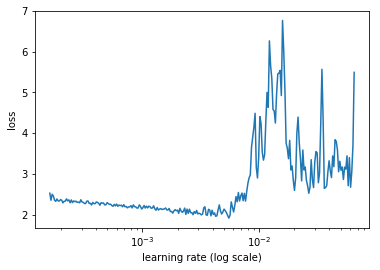

In [0]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

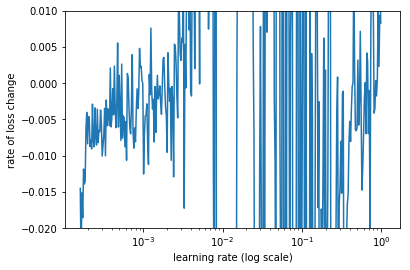

In [0]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.02, 0.01))

In [0]:
sma = 25
n_skip_beginning = 20
n_skip_end = 5

best_lr = lr_finder.get_best_lr(sma, n_skip_beginning=n_skip_beginning, n_skip_end=n_skip_end)
print('The best Learning Rate is: ', best_lr)

[0, 0, 0, 0, 0, -0.035581741333007816, -0.036949806213378907, -0.0309893798828125, -0.029012451171875, -0.017545547485351563, -0.022053337097167967, -0.023700981140136718, -0.020186634063720704, -0.014279251098632812, -0.012783079147338868, -0.009726591110229492, -0.010219478607177734, -0.006273984909057617, -0.008698492050170899, -0.010853099822998046, -0.006972875595092774, -0.004703083038330078, -0.007145757675170898, -0.007868671417236328, -0.00535787582397461, -0.009467401504516602, 0.00042633056640625, -0.007550535202026368, -0.006162824630737304, -0.0032217597961425783, -0.0021762752532958982, -0.0021586704254150393, -4.384040832519531e-05, -0.0024476242065429687, -0.003636198043823242, -0.004726829528808593, 0.0004627227783203125, -0.0022898292541503906, -0.0024710178375244142, -0.003081188201904297, -0.001562328338623047, -0.0034238243103027343, -0.002497434616088867, -0.0026622867584228517, -0.0005126762390136719, -0.0020394515991210937, -0.003128719329833984, -0.003603725433

## Cyclic Learning Rate

In [0]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import binary_accuracy

class CyclicLR(Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum): 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        print("On CLR INIT")
        
    def clr(self):
        # called after every batch                 
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        # called after every batch 
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        print("On CLR on_train_begin method")
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        # called after every batch  
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())
            

## Run with Batch size 128 epochs 100
 
 * Crop generator
 * Image augmentation

Run1:
* SGD with Decay
* Random crop
* Random erasing

Run 2:
* SGD with Decay
* Random crop
* height shift range - 0.5
* 87

Run 3:
* Run 2 and 
* rotation_range=90
* 74.6

Run 4:
* SGD with Decay
* Random crop
* Random erasing
* min LR divide by 2
* momentum - 9.8 to 8.8
* 88.59

Run 5:
 * Run 4 and
 * height shift range - 0.5
 * 87.97
 
 
 Run 6:
 * Run 5
 * Remove Weight Decay
 * 91.53
 
 
Final Run:
* From Run6
* Remove Cutout
*  92.16

In [0]:
# from PIL import Image
model = DavidNet()
# sgd = SGD(decay=WEIGHT_DECAY)
sgd = SGD()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

best_lr = 0.013487148
base_lr = best_lr/2
max_lr = best_lr*2
step_size = 1171

max_m = 0.98
base_m = 0.88

cyclical_momentum = True
augment = True
cycles = 2.35

iterations = round(len(train_features)/BATCH_SIZE*EPOCHS)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)


# datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.5, rotation_range=90)
datagen = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.5)
# datagen = ImageDataGenerator(horizontal_flip=True)

steps_per_epoch = train_features.shape[0]/BATCH_SIZE

# train the model
start = time.time()
# Train the model

# BATCH_SIZE = 1 # TODO : REMOVE
# crop_length = 32
# filepath = r'/content/drive/My Drive/EVA-MachineLearning/'
# train_data = datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE, save_to_dir=filepath, save_prefix="image", save_format="jpg")
train_data = datagen.flow(train_features, train_labels, batch_size = BATCH_SIZE)


train_crops = crop_generator(train_data, 32)
print(train_crops)

model_info = model.fit_generator(train_crops, 
                                      steps_per_epoch = steps_per_epoch, epochs=EPOCHS,
                                      validation_data=(test_features, test_labels), verbose=1,
                                    callbacks=[clr])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

On CLR INIT
<generator object crop_generator at 0x7fcc3026c938>
On CLR on_train_begin method
Epoch 1/100
391/390 [==============================] - 73s 188ms/step - loss: 2.0387 - acc: 0.3082 - val_loss: 1.7650 - val_acc: 0.3759
Epoch 2/100
391/390 [==============================] - 71s 183ms/step - loss: 1.6443 - acc: 0.4188 - val_loss: 1.4663 - val_acc: 0.4816
Epoch 3/100
391/390 [==============================] - 72s 183ms/step - loss: 1.4807 - acc: 0.4756 - val_loss: 1.4417 - val_acc: 0.4987
Epoch 4/100
391/390 [==============================] - 72s 183ms/step - loss: 1.3508 - acc: 0.5213 - val_loss: 1.4838 - val_acc: 0.5054
Epoch 5/100
391/390 [==============================] - 72s 183ms/step - loss: 1.2780 - acc: 0.5509 - val_loss: 1.2785 - val_acc: 0.5604
Epoch 6/100
391/390 [==============================] - 71s 183ms/step - loss: 1.1882 - acc: 0.5820 - val_loss: 1.2675 - val_acc: 0.5955
Epoch 7/100
391/390 [==============================] - 71s 183ms/step - loss: 1.1308 - acc:

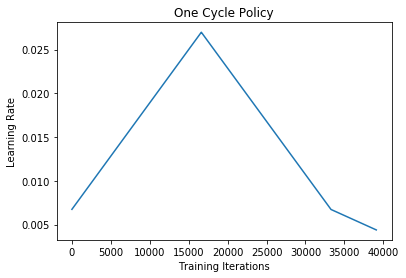

In [0]:
# Plot Learning Rate

import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

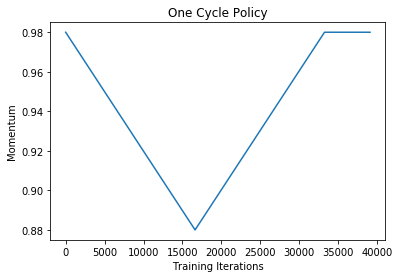

In [0]:
# Plot momentum

plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()